In [1]:
import os, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from extract23 import extract_url_features, feature_names

In [2]:
tqdm_kwargs = dict(leave=False, dynamic_ncols=True)

RANDOM_STATE = 42
URLS_PER_MAIL_CAP = 5
POOL_STRATEGY = "max"
models = {}
DATA_DIR = Path("0814Dataset")
DATASETS = [
    ("CEAS_08", "CEAS_08_emails_sorted.csv"),
    ("TREC_07", "TREC_07_emails_sorted.csv"),
    ("C08T07Spam", "merged_C08T07Spam_emails_sorted.csv"),
    ("New_Proportion", "new_proportion_dataset_sorted.csv"),
]
BODY_COL = "body"
#LABEL_COL = "label"


IGNORE_URLS_IN_BERT = True
URL_PLACEHOLDER = "[URL]"     

URL_REPLACE = re.compile(
    r"""(?ix)\b(?:(?:https?://)|(?:www\.))[^\s<>'"(){}\[\]]+|\b\w+://[^\s<>'"(){}\[\]]+""".strip()
)

def replace_urls_with_placeholder(text: str) -> str:
    # replace url to [URL]
    if not isinstance(text, str):
        return ""
    return URL_REPLACE.sub(URL_PLACEHOLDER, text.strip())

def text_embeddings(corpus):

    print("[Stage]: SBERT (all-MiniLM-L6-v2, 384D)")
    sb = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cpu")
    #let [URL] become one of tokenizer
    added = sb.tokenizer.add_special_tokens({"additional_special_tokens": [URL_PLACEHOLDER]})
    if added > 0:
        sb[0].auto_model.resize_token_embeddings(len(sb.tokenizer), mean_resizing=False)
    url_token_id = sb.tokenizer.convert_tokens_to_ids(URL_PLACEHOLDER)

    # SBERT ignore URL 
    texts = list(corpus)
    if IGNORE_URLS_IN_BERT:
        texts = [replace_urls_with_placeholder(t) for t in texts]

    all_embeds = []
    for i in tqdm(range(0, len(texts), 64), desc="[SBERT] encoding", **tqdm_kwargs):
        batch = texts[i:i+64]

        # tokenizer get features
        features = sb.tokenize(batch)
        # put [URL] attention_mask set 0
        input_ids = features["input_ids"]
        attn = features["attention_mask"]
        mask_pos = (input_ids == url_token_id)
        attn[mask_pos] = 0
        features["attention_mask"] = attn

        with torch.no_grad():
            out = sb(features)
            emb = out["sentence_embedding"].cpu().numpy()

        all_embeds.append(emb)

    X = np.vstack(all_embeds).astype("float32")
    print(f"[Stage] finish: SBERT, shape={X.shape}")
    return X, "sbert-all-MiniLM-L6-v2"

# URL features
def urls_to_list_column(df: pd.DataFrame, body_col: str = "body") -> pd.Series:
    def _extract(text):
        if not isinstance(text, str): return []
        urls = URL_REPLACE.findall(text)
        cleaned = [u.strip('()[]<>"\' ,;.!?') for u in urls]
        if URLS_PER_MAIL_CAP > 0 and len(cleaned) > URLS_PER_MAIL_CAP:
            cleaned = cleaned[:URLS_PER_MAIL_CAP]
        return cleaned
    return df[body_col].apply(_extract)

def _pool_urls(urls):
    D = len(feature_names)
    if not urls: return np.zeros((D,), dtype=float)
    mat = extract_url_features(pd.Series(urls))
    agg = np.nanmax(mat, axis=0) if POOL_STRATEGY=="max" else np.nanmean(mat, axis=0)
    return agg.astype("float32")

def extract_url_features_multi_with_progress(url_lists: pd.Series) -> np.ndarray:
    rows = []
    for urls in tqdm(url_lists, desc="[URL] features", **tqdm_kwargs):
        rows.append(_pool_urls(urls or []))
    return np.vstack(rows).astype("float32")


In [3]:
# Classier
def _ensure_proba_or_score(clf, X):
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:, 1]
    if hasattr(clf, "decision_function"):
        s = clf.decision_function(X)
        return s if s.ndim==1 else s[:,1]
    return clf.predict(X)

def make_calibrated_linear_svc():
    base = LinearSVC(dual=False, class_weight="balanced", random_state=RANDOM_STATE)
    return CalibratedClassifierCV(estimator=base, method="sigmoid", cv=5)

def train_models(X_tr, y_tr):
    
    svc = make_calibrated_linear_svc()
    svc_pipe = Pipeline([("scaler", StandardScaler()), ("clf", svc)])
    svc_pipe.fit(X_tr, y_tr); models["LinearSVC"] = svc_pipe

    rf = RandomForestClassifier(
        n_estimators=200, n_jobs=-1,
        random_state=RANDOM_STATE, class_weight="balanced_subsample"
    )
    rf.fit(X_tr, y_tr); models["RandomForest"] = rf

    mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(512,256),
                              activation="relu", max_iter=30,
                              learning_rate_init=1e-3,
                              random_state=RANDOM_STATE))
    ])
    mlp.fit(X_tr, y_tr); models["MLP"] = mlp
    return models

In [4]:
# Evaluation and charts
def evaluate_and_plot(name, clf, X_te, y_te, metrics_dict, curves_dict):
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="macro", zero_division=0)
    print(f"\n[{name}] Acc={acc:.4f} | F1={f1:.4f} | Prec={prec:.4f} | Rec={rec:.4f}")
    print(classification_report(y_te, y_pred, digits=4))

    metrics_dict[name] = dict(Acc=acc, F1=f1, Prec=prec, Rec=rec)

    # Confusion Matrix
    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC
    y_score = _ensure_proba_or_score(clf, X_te)
    fpr, tpr, _ = roc_curve(y_te, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"ROC - {name}"); plt.legend(); plt.show()

    # PR
    precs, recalls, _ = precision_recall_curve(y_te, y_score)
    plt.figure(figsize=(5,4))
    plt.plot(recalls, precs, label=f"{name}")
    plt.title(f"PR - {name}"); plt.legend(); plt.show()

    curves_dict[name] = dict(fpr=fpr, tpr=tpr, roc_auc=roc_auc, precs=precs, recalls=recalls)




========== Running CEAS_08 ==========


[CEAS_08] Progress:   0%|                                 | 0/5 [00:00<?, ?it/s]

[Stage]: SBERT (all-MiniLM-L6-v2, 384D)


[SBERT] encoding:   0%|                                 | 0/567 [00:00<?, ?it/s]

[Stage] finish: SBERT, shape=(36233, 384)


[URL] features:   0%|                                 | 0/36233 [00:00<?, ?it/s]

[FeatureFusion] text=384D + URL=23D → totalD=407

[LinearSVC] Acc=0.9908 | F1=0.9907 | Prec=0.9910 | Rec=0.9904
              precision    recall  f1-score   support

           0     0.9943    0.9856    0.9899      3344
           1     0.9878    0.9951    0.9914      3903

    accuracy                         0.9908      7247
   macro avg     0.9910    0.9904    0.9907      7247
weighted avg     0.9908    0.9908    0.9908      7247



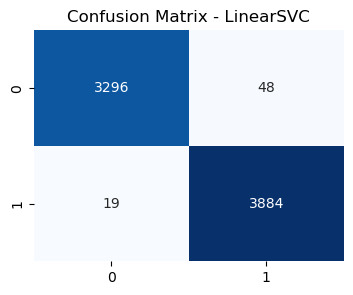

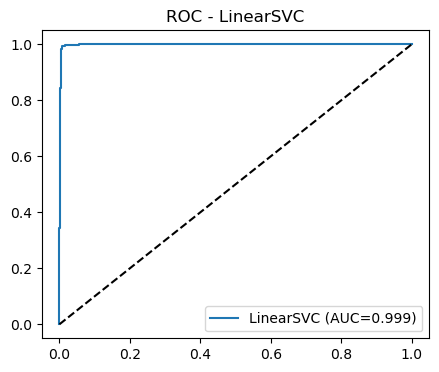

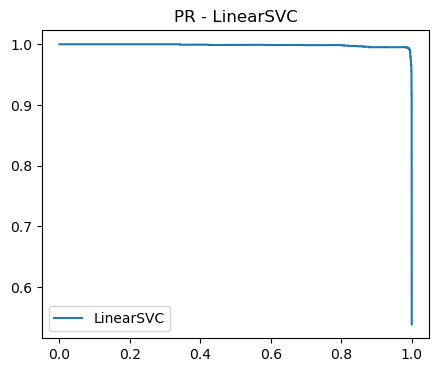


[RandomForest] Acc=0.9928 | F1=0.9928 | Prec=0.9928 | Rec=0.9927
              precision    recall  f1-score   support

           0     0.9928    0.9916    0.9922      3344
           1     0.9928    0.9939    0.9933      3903

    accuracy                         0.9928      7247
   macro avg     0.9928    0.9927    0.9928      7247
weighted avg     0.9928    0.9928    0.9928      7247



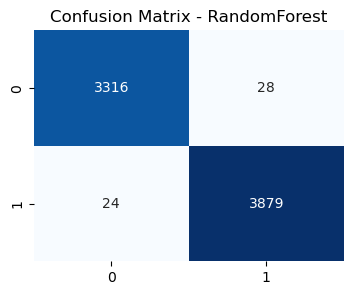

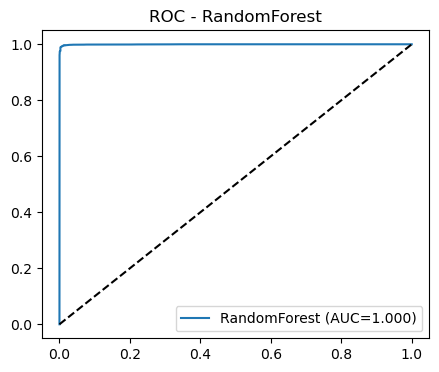

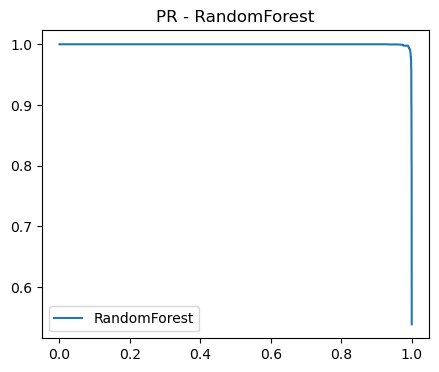


[MLP] Acc=0.9960 | F1=0.9960 | Prec=0.9961 | Rec=0.9959
              precision    recall  f1-score   support

           0     0.9967    0.9946    0.9957      3344
           1     0.9954    0.9972    0.9963      3903

    accuracy                         0.9960      7247
   macro avg     0.9961    0.9959    0.9960      7247
weighted avg     0.9960    0.9960    0.9960      7247



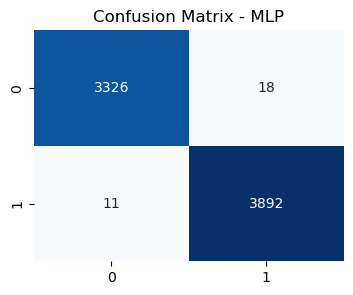

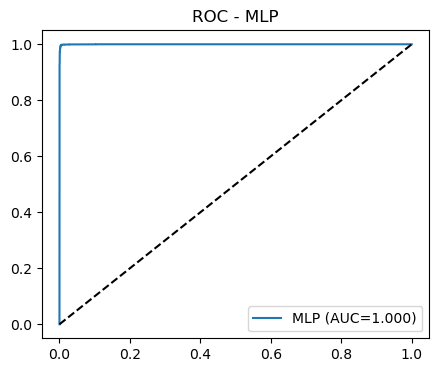

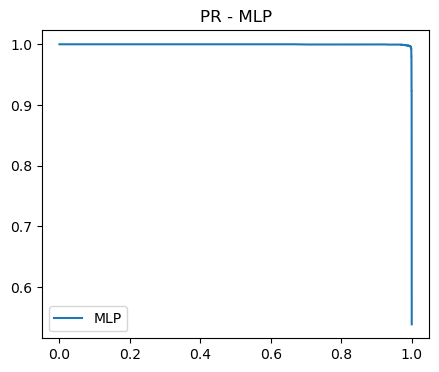

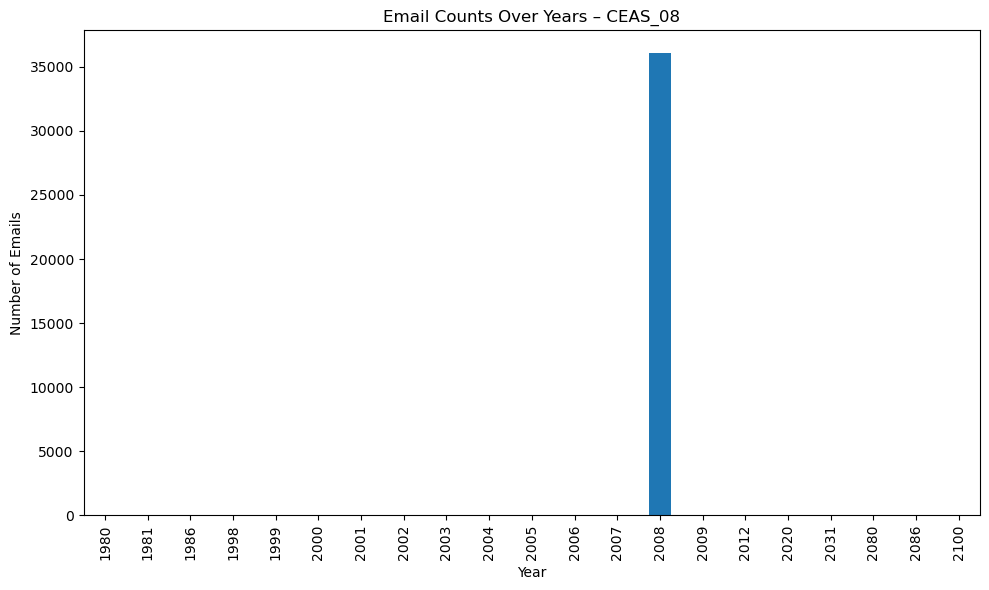


========== Running TREC_07 ==========


[TREC_07] Progress:   0%|                                 | 0/5 [00:00<?, ?it/s]

[Stage]: SBERT (all-MiniLM-L6-v2, 384D)


[SBERT] encoding:   0%|                                 | 0/803 [00:00<?, ?it/s]

[Stage] finish: SBERT, shape=(51355, 384)


[URL] features:   0%|                                 | 0/51355 [00:00<?, ?it/s]

[FeatureFusion] text=384D + URL=23D → totalD=407

[LinearSVC] Acc=0.9780 | F1=0.9779 | Prec=0.9781 | Rec=0.9777
              precision    recall  f1-score   support

           0     0.9804    0.9727    0.9765      4837
           1     0.9759    0.9827    0.9793      5434

    accuracy                         0.9780     10271
   macro avg     0.9781    0.9777    0.9779     10271
weighted avg     0.9780    0.9780    0.9780     10271



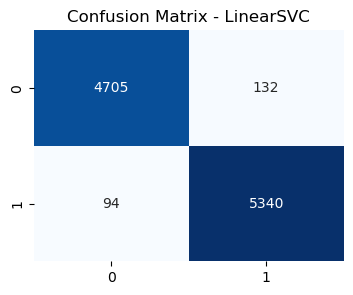

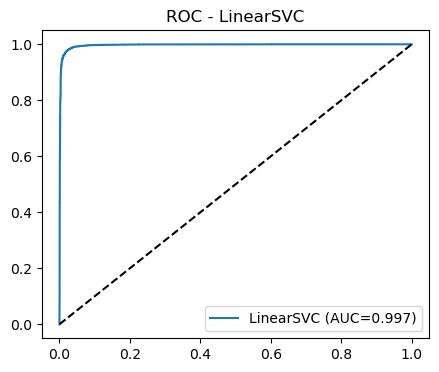

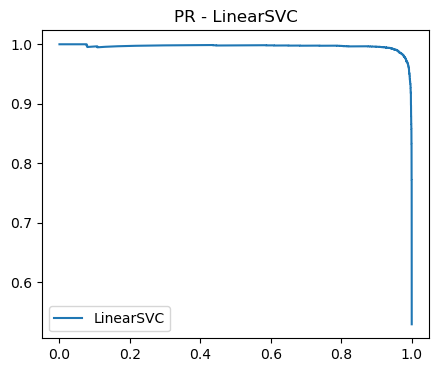


[RandomForest] Acc=0.9788 | F1=0.9787 | Prec=0.9788 | Rec=0.9786
              precision    recall  f1-score   support

           0     0.9796    0.9752    0.9774      4837
           1     0.9780    0.9820    0.9800      5434

    accuracy                         0.9788     10271
   macro avg     0.9788    0.9786    0.9787     10271
weighted avg     0.9788    0.9788    0.9788     10271



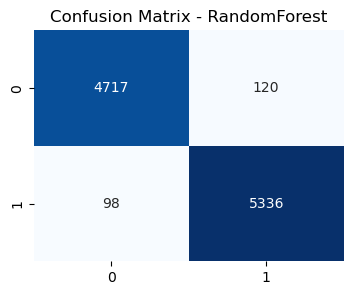

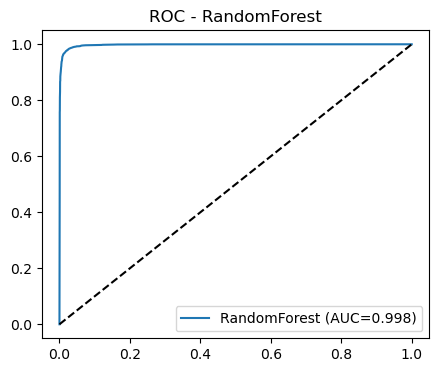

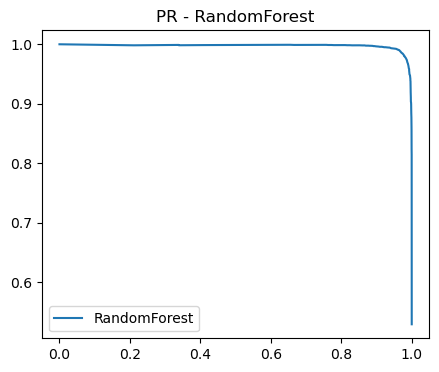


[MLP] Acc=0.9916 | F1=0.9916 | Prec=0.9918 | Rec=0.9914
              precision    recall  f1-score   support

           0     0.9950    0.9872    0.9911      4837
           1     0.9887    0.9956    0.9921      5434

    accuracy                         0.9916     10271
   macro avg     0.9918    0.9914    0.9916     10271
weighted avg     0.9917    0.9916    0.9916     10271



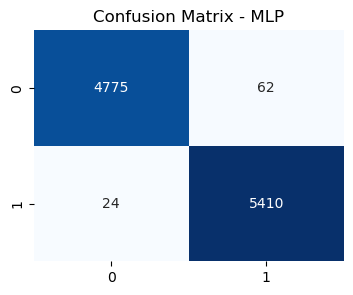

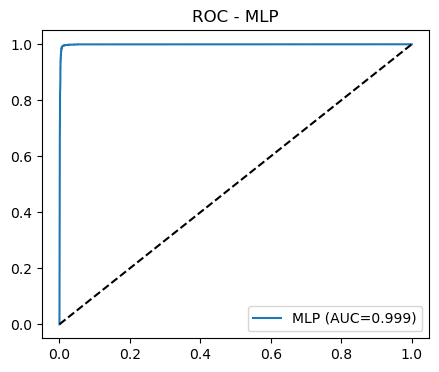

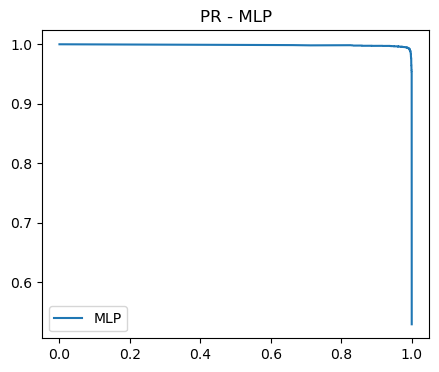

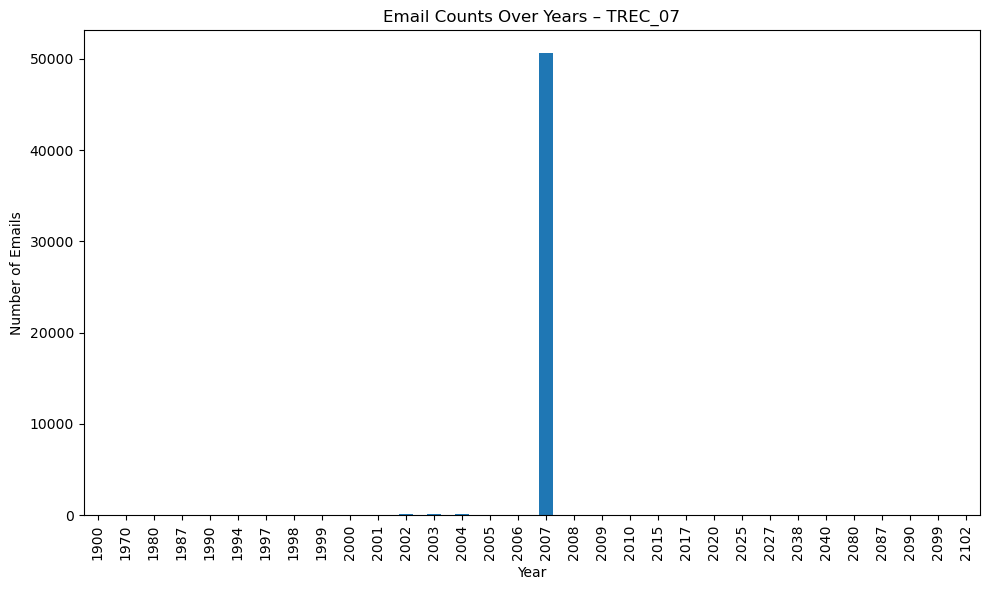


========== Running C08T07Spam ==========


[C08T07Spam] Progress:   0%|                              | 0/5 [00:00<?, ?it/s]

[Stage]: SBERT (all-MiniLM-L6-v2, 384D)


[SBERT] encoding:   0%|                                | 0/1447 [00:00<?, ?it/s]

[Stage] finish: SBERT, shape=(92572, 384)


[URL] features:   0%|                                 | 0/92572 [00:00<?, ?it/s]

[FeatureFusion] text=384D + URL=23D → totalD=407

[LinearSVC] Acc=0.9705 | F1=0.9705 | Prec=0.9705 | Rec=0.9704
              precision    recall  f1-score   support

           0     0.9706    0.9680    0.9693      8904
           1     0.9704    0.9728    0.9716      9611

    accuracy                         0.9705     18515
   macro avg     0.9705    0.9704    0.9705     18515
weighted avg     0.9705    0.9705    0.9705     18515



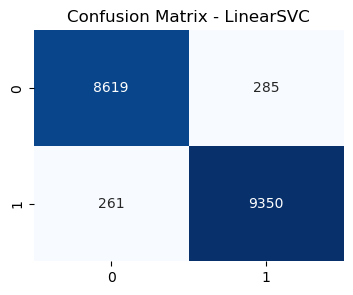

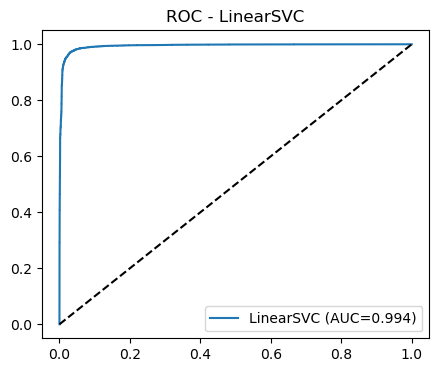

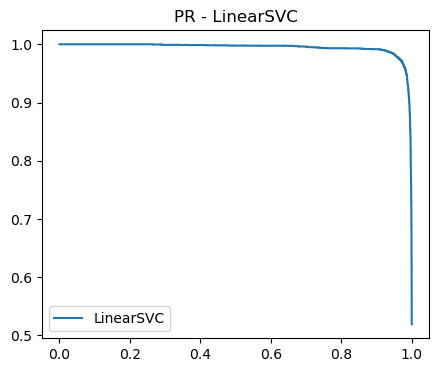


[RandomForest] Acc=0.9708 | F1=0.9707 | Prec=0.9706 | Rec=0.9709
              precision    recall  f1-score   support

           0     0.9664    0.9730    0.9697      8904
           1     0.9749    0.9687    0.9718      9611

    accuracy                         0.9708     18515
   macro avg     0.9706    0.9709    0.9707     18515
weighted avg     0.9708    0.9708    0.9708     18515



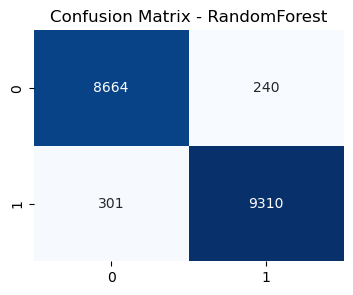

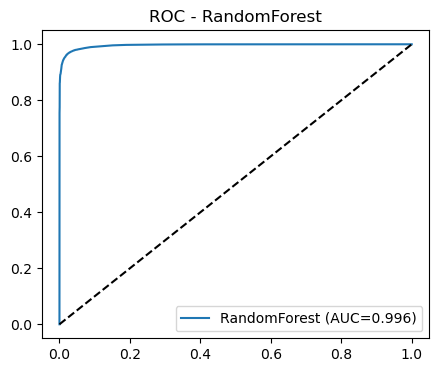

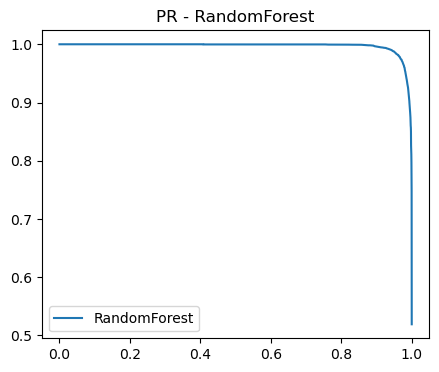


[MLP] Acc=0.9731 | F1=0.9731 | Prec=0.9729 | Rec=0.9735
              precision    recall  f1-score   support

           0     0.9620    0.9829    0.9723      8904
           1     0.9839    0.9640    0.9738      9611

    accuracy                         0.9731     18515
   macro avg     0.9729    0.9735    0.9731     18515
weighted avg     0.9733    0.9731    0.9731     18515



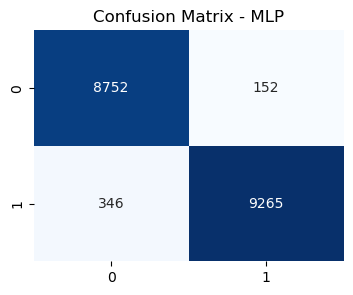

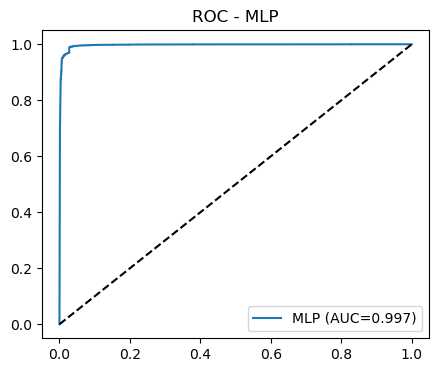

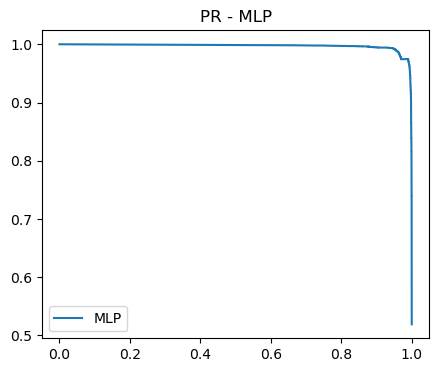

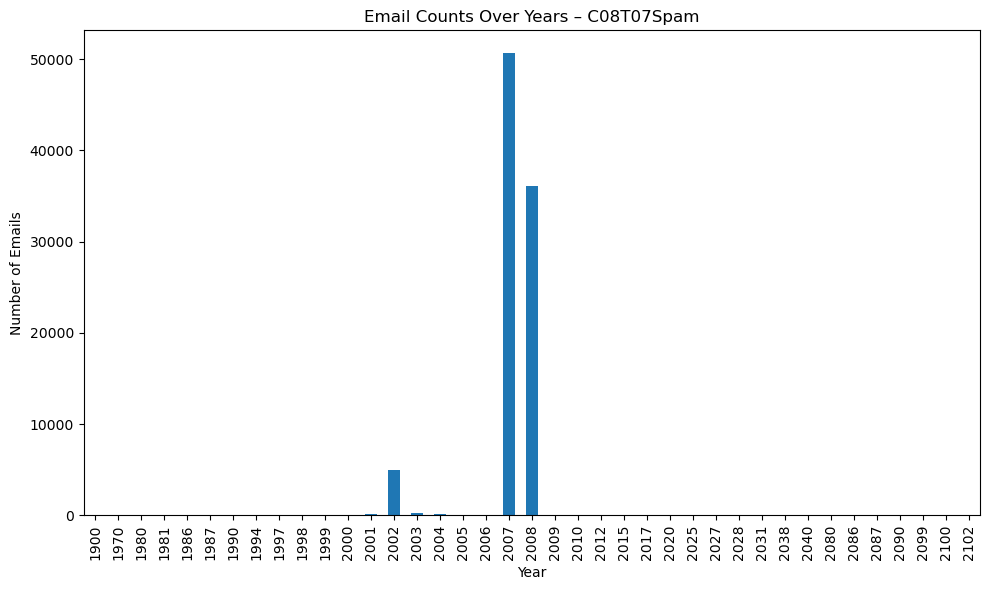


========== Running New_Proportion ==========


[New_Proportion] Progress:   0%|                          | 0/5 [00:00<?, ?it/s]

[Stage]: SBERT (all-MiniLM-L6-v2, 384D)


[SBERT] encoding:   0%|                                 | 0/773 [00:00<?, ?it/s]

[Stage] finish: SBERT, shape=(49451, 384)


[URL] features:   0%|                                 | 0/49451 [00:00<?, ?it/s]

[FeatureFusion] text=384D + URL=23D → totalD=407

[LinearSVC] Acc=0.9816 | F1=0.9487 | Prec=0.9487 | Rec=0.9487
              precision    recall  f1-score   support

           0     0.9898    0.9898    0.9898      8905
           1     0.9077    0.9077    0.9077       986

    accuracy                         0.9816      9891
   macro avg     0.9487    0.9487    0.9487      9891
weighted avg     0.9816    0.9816    0.9816      9891



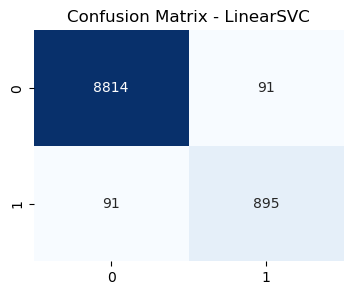

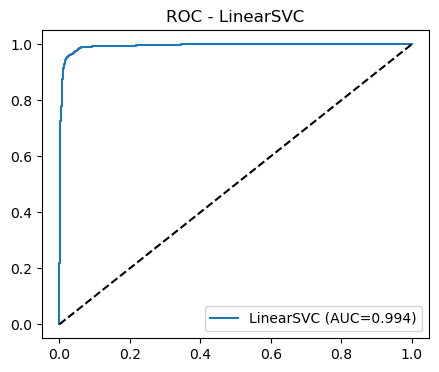

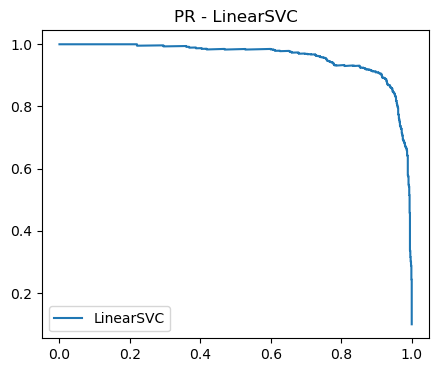


[RandomForest] Acc=0.9673 | F1=0.8935 | Prec=0.9804 | Rec=0.8376
              precision    recall  f1-score   support

           0     0.9653    0.9997    0.9822      8905
           1     0.9955    0.6755    0.8048       986

    accuracy                         0.9673      9891
   macro avg     0.9804    0.8376    0.8935      9891
weighted avg     0.9683    0.9673    0.9645      9891



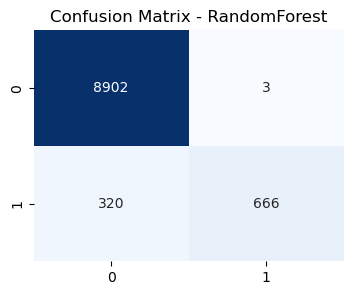

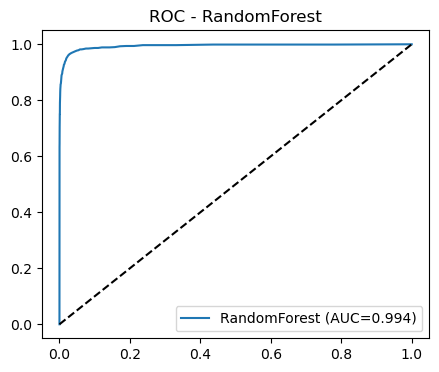

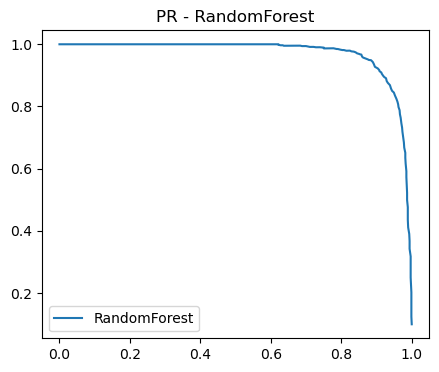


[MLP] Acc=0.9873 | F1=0.9651 | Prec=0.9578 | Rec=0.9726
              precision    recall  f1-score   support

           0     0.9949    0.9909    0.9929      8905
           1     0.9207    0.9544    0.9373       986

    accuracy                         0.9873      9891
   macro avg     0.9578    0.9726    0.9651      9891
weighted avg     0.9875    0.9873    0.9874      9891



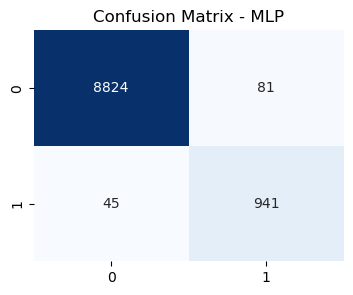

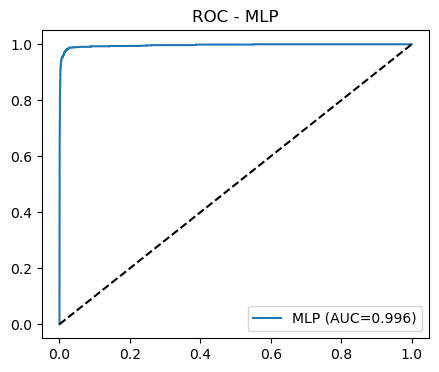

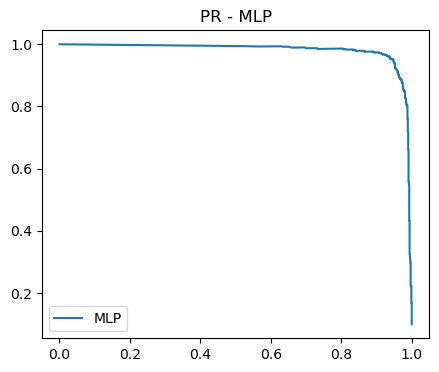

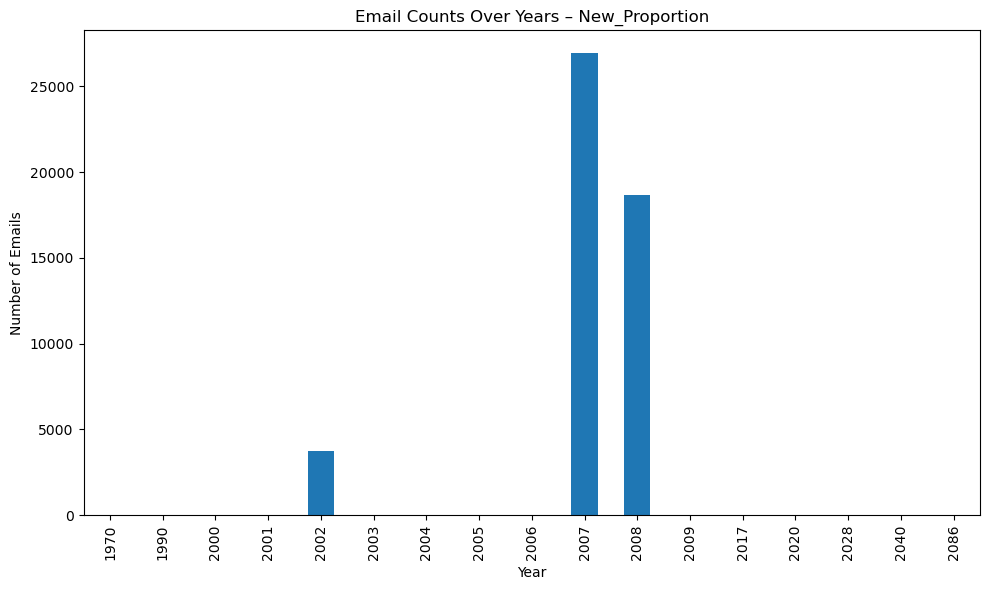


 performance comparison table
             CEAS_08                         TREC_07                          \
                 Acc      F1    Prec     Rec     Acc      F1    Prec     Rec   
LinearSVC     0.9908  0.9907  0.9910  0.9904  0.9780  0.9779  0.9781  0.9777   
MLP           0.9960  0.9960  0.9961  0.9959  0.9916  0.9916  0.9918  0.9914   
RandomForest  0.9928  0.9928  0.9928  0.9927  0.9788  0.9787  0.9788  0.9786   

             C08T07Spam                         New_Proportion          \
                    Acc      F1    Prec     Rec            Acc      F1   
LinearSVC        0.9705  0.9705  0.9705  0.9704         0.9816  0.9487   
MLP              0.9731  0.9731  0.9729  0.9735         0.9873  0.9651   
RandomForest     0.9708  0.9707  0.9706  0.9709         0.9673  0.8935   

                              
                Prec     Rec  
LinearSVC     0.9487  0.9487  
MLP           0.9578  0.9726  
RandomForest  0.9804  0.8376  


In [5]:
summary_results = {}

def run_one_dataset(csv_path: Path, ds_name: str):
    print("\n" + "="*10 + f" Running {ds_name} " + "="*10)
    df = pd.read_csv(csv_path)
    y = df["label"].values.astype(int)

    steps = ["bodyFeatures", "URLFeatures", "FeatureFusion", "Trainning", "Evaluation"]
    with tqdm(total=len(steps), desc=f"[{ds_name}] Progress", **tqdm_kwargs) as pbar:

        X_text, _ = text_embeddings(df[BODY_COL].astype(str).fillna(""))
        pbar.update(1)

        df["url_list"] = urls_to_list_column(df, body_col=BODY_COL)
        X_url = extract_url_features_multi_with_progress(df["url_list"])
        pbar.update(1)

        X = np.hstack([X_text, X_url])
        print(f"[FeatureFusion] text={X_text.shape[1]}D + URL={X_url.shape[1]}D → totalD={X.shape[1]}")
        pbar.update(1)


        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        models = train_models(X_tr, y_tr)
        pbar.update(1)

        metrics_dict, curves_dict = {}, {}
        for mname, clf in models.items():
            evaluate_and_plot(mname, clf, X_te, y_te, metrics_dict, curves_dict)
            for metric, val in metrics_dict[mname].items():
                summary_results[(ds_name, mname, metric)] = val
        pbar.update(1)

        if "date" in df.columns:
            df["date"] = pd.to_datetime(df["date"], errors="coerce")
            
            yearly_counts = df.groupby(df["date"].dt.to_period("Y")).size()
        
            plt.figure(figsize=(10,6))
            yearly_counts.plot(kind="bar")
            plt.title(f"Email Counts Over Years – {ds_name}")
            plt.xlabel("Year")
            plt.ylabel("Number of Emails")
            plt.tight_layout()
            plt.show()

def main():
    for ds_name, fname in DATASETS:
        csv_path = DATA_DIR / fname
        if not csv_path.exists():
            print(f"[skip] {csv_path} not exist"); continue
        run_one_dataset(csv_path, ds_name)

    if summary_results:
        df_summary = pd.Series(summary_results).unstack(level=[0,2])
        print("\n performance comparison table")
        print(df_summary.round(4))
        df_summary.to_csv("results_summary1.85.csv")

if __name__ == "__main__":
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    warnings.filterwarnings("ignore", category=UserWarning)
    main()
